## Baseline classification results for catinous

In [1]:
from pytorch_lightning import Trainer
#from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
import catinous.CatsinomModelLogitsCache as catslogmodel
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve, accuracy_score
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
from py_jotools import mut, cache
import SimpleITK as sitk

import catinous.utils as catutils


%load_ext autoreload
%autoreload 2

In [151]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

# Loading test sets

In [16]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not catsmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)    
        else:
            _, df_temp, _, _ = catsmodel.trained_model(base_params[-1])
            df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

# BWT/FWT/Accuracies

In [2]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='test', res='lr'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='test', res='hr'), batch_size=8, num_workers=4)
test_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='test', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [3]:
val_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='val', res='lr'), batch_size=8, num_workers=4)
val_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='val', res='hr'), batch_size=8, num_workers=4)
val_hr_ts = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dsts3_dataset.csv', split='val', res='hr_ts'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [6]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def test_metrices(hparams, datasets, device, suffix='.pt'):
    roc_aucs = dict()
    accuracies = dict()
    
    for i in range(1, 6):
        hparams['run_postfix'] = i
        model = catslogmodel.CatsinomModelLogitsCache(hparams=hparams, device=device)
        exp_name = catutils.get_expname(model.hparams)
        weights_path = catutils.TRAINED_MODELS_FOLDER + exp_name + suffix
        if os.path.exists(weights_path):
            if suffix == '.pt': #HACK hack hack
                print('loading', weights_path)
                model.load_state_dict(torch.load(weights_path))
            else:
                model.model.load_state_dict(torch.load(weights_path))
            model.to(device)
            model.freeze()
        
            for ds in datasets:
                target, output = test_model(model, datasets[ds], device)

                #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')

                output_bin = [int(o>0.5) for o in output]
                fpr, tpr, _ = roc_curve(target, output)

                if i==1:
                    roc_aucs[ds] = list()
                    accuracies[ds] = list()
                    
                roc_aucs[ds].append(auc(fpr, tpr))
                accuracies[ds].append(accuracy_score(target, output_bin))
        else:
            print('model checkpoint doesnt exist', weights_path)
            
    return (roc_aucs, accuracies)

def get_rocs_accuracies_bwts_fwts(hparams, datasets):
    roc_aucs_lr, accuracies_lr = test_metrices(hparams, datasets, device, suffix='_lr_checkpoint.pt')
    roc_aucs_hr, accuracies_hr = test_metrices(hparams, datasets, device, suffix='_hr_checkpoint.pt')
    roc_aucs_end, accuracies_end = test_metrices(hparams, datasets, device, suffix='.pt')


    bwts=[]
    fwts=[]
    for i in range(len(accuracies_lr['LR'])):
        R = np.array([[accuracies_lr['LR'][i], accuracies_lr['HR'][i], accuracies_lr['HR TS'][i]],
                  [accuracies_hr['LR'][i], accuracies_hr['HR'][i], accuracies_hr['HR TS'][i]],
                  [accuracies_end['LR'][i], accuracies_end['HR'][i], accuracies_end['HR TS'][i]]])

        bwts.append(((R[2][0] - R[0][0]) + (R[2][1] - R[1][1]))/2)
        fwts.append((R[0][1]-0.5 + R[1][2]-0.5)/2)
        
    return roc_aucs_lr, roc_aucs_hr, roc_aucs_end, accuracies_lr, accuracies_hr, accuracies_end, bwts, fwts

In [10]:
hparams={'continous': True,
         'use_cache':True,
        'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
        'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
        'val_check_interval': 30,
        'cachemaximum':32,
        'force_misclassified':True}

(roc_aucs_val, accuracies_val) = test_metrices(hparams, {'LR': val_lr, 'HR': val_hr, 'HR TS': val_hr_ts}, device)

print('LR', np.array(accuracies_val['LR']).mean(), np.array(accuracies_val['LR']).std())
print('HR', np.array(accuracies_val['HR']).mean(), np.array(accuracies_val['HR']).std())
print('HR TS', np.array(accuracies_val['HR TS']).mean(), np.array(accuracies_val['HR TS']).std())
print('mean', np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).mean(), np.array([accuracies_val['LR'], accuracies_val['HR'], accuracies_val['HR TS']]).std())

INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_1_d6d3a4b8c8.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_2_724bdb10dc.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_3_54465ad537.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_4_8ee373c98a.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_5_09d8b99615.pt
LR 0.709814323607427 0.07882225188905362
HR 0.769811320754717 0.05443159145944018
HR TS 0.9580188679245282 0.01574369742290435
mean 0.8125481707622241 0.11967457956598937


In [14]:
hparams={'continous': True,
         'use_cache':True,
        'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
        'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
        'val_check_interval': 30,
        'cachemaximum':32,
        'force_misclassified':True}

(roc_aucs_test, accuracies_test) = test_metrices(hparams, {'LR': test_lr, 'HR': test_hr, 'HR TS': test_hr_ts}, device)

print('LR', np.array(accuracies_test['LR']).mean(), np.array(accuracies_test['LR']).std())
print('HR', np.array(accuracies_test['HR']).mean(), np.array(accuracies_test['HR']).std())
print('HR TS', np.array(accuracies_test['HR TS']).mean(), np.array(accuracies_test['HR TS']).std())
print('mean', np.array([accuracies_test['LR'], accuracies_test['HR'], accuracies_test['HR TS']]).mean(), np.array([accuracies_test['LR'], accuracies_test['HR'], accuracies_test['HR TS']]).std())

INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_1_d6d3a4b8c8.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_2_724bdb10dc.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_3_54465ad537.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_4_8ee373c98a.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32


loading /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_5_09d8b99615.pt
LR 0.7128608923884514 0.06829394308032488
HR 0.7789227166276347 0.05170501965238625
HR TS 0.9511737089201878 0.01926599486261331
mean 0.8143191059787579 0.11252333995968353


In [29]:
df_cache = pd.read_csv('/project/catinous/trained_cache/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_2_724bdb10dc.csv')
df_cache.groupby('res').count()

,filepath,label,traincounter
res,,,
hr_ts,30,30,30
lr,2,2,2


In [21]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dsts2_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'hr'
res[streamedDS.df.res == 'hr_ts'] = 2
newcmp = ListedColormap([sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]], name='OrangeBlue')

Load: /home/mperkonigg/zzz/__main__.res_data_for_params_cee5e3f299f69c0a5197608e6e1068d22f499d84.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_4f1753dd7e9c890be4a037aa3166e0ad4df68bd6.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_00d49c59e3e8ef04477454eb503742f8cf1a5e27.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_3ca5064e01b971f79169548951366679ff9e357f.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_3354d16c54f4c408dcb1fc74af7f21e9ddcc55ee.p in: 0.00s
Load: /home/mperkonigg/zzz/__main__.res_data_for_params_496f8e6bdae02cf7a39c80a61b65b39c9c6075be.p in: 0.00s


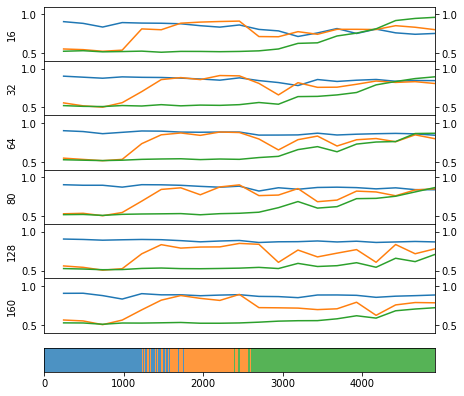

In [29]:
c_sizes = [16, 32, 48, 64, 80, 96, 128, 160]
c_sizes = [16, 32, 64, 80, 128, 160]
datas = ['catsinom_combined_dsts3_dataset.csv']
fig, ax = plt.subplots(7,1, figsize=(7, 7), frameon=False)
plt.subplots_adjust(hspace=0.0)
for j, c_size in enumerate(c_sizes):
    hparams={'continous': True,
             'use_cache':True,
            'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
            'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
            'val_check_interval': 30,
            'cachemaximum': c_size,
            'force_misclassified':True}
    t_ews_res = cache.cache(res_data_for_params,hparams)

    axis = ax[j]
    sns.lineplot(data=t_ews_res, y='val_acc_lr', x='idx', ax=axis, err_style=None)
    sns.lineplot(data=t_ews_res, y='val_acc_hr', x='idx', ax=axis, err_style=None)
    sns.lineplot(data=t_ews_res, y='val_acc_hr_ts', x='idx', ax=axis, err_style=None)
    axis.get_xaxis().set_visible(False)
    axis.set_xlim(0, 20)
    axis.set_ylim(.4, 1.1)
    axis.set_ylabel('')
    axis.set_ylabel(r'%i' % c_size)
    axis.tick_params(labelright=True, right=True)
    axis.get_xaxis().set_visible(False)

ax[6].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[6].get_yaxis().set_visible(False)
ax[6].get_yaxis()
plt.savefig(catutils.RESPATH+ 'memory_size_effect_learning.pdf', bbox_inches='tight', pad_inches=0.1)

In [24]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not catslogmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)    
        else:
            _, df_temp, _, _ = catslogmodel.trained_model(base_params[-1])
            df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

INFO:root:Logits hooks and cache initialized. Cachesize: 32
INFO:root:Logits hooks and cache initialized. Cachesize: 32


Read: /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_1_d6d3a4b8c8.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32
INFO:root:Logits hooks and cache initialized. Cachesize: 32


Read: /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_2_724bdb10dc.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32
INFO:root:Logits hooks and cache initialized. Cachesize: 32


Read: /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_3_54465ad537.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32
INFO:root:Logits hooks and cache initialized. Cachesize: 32


Read: /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_4_8ee373c98a.pt


INFO:root:Logits hooks and cache initialized. Cachesize: 32
INFO:root:Logits hooks and cache initialized. Cachesize: 32


Read: /project/catinous/trained_models/cont_combined_logits_basemodel_lr_fmiss_cache_tf07_5_09d8b99615.pt


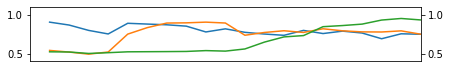

In [25]:
fig, ax = plt.subplots(1,1, figsize=(7, 1), frameon=False)
plt.subplots_adjust(hspace=0.0)
hparams={'continous': True,
         'use_cache':True,
        'datasetfile': 'catsinom_combined_dsts3_dataset.csv',
        'base_model': 'batch_lr_base_train_1_2d20289ac9.pt',
        'val_check_interval': 30,
        'cachemaximum':32,
        'force_misclassified':True}

t_ews_res = res_data_for_params(hparams)

axis = ax
sns.lineplot(data=t_ews_res, y='val_acc_lr', x='idx', ax=axis, err_style=None)
sns.lineplot(data=t_ews_res, y='val_acc_hr', x='idx', ax=axis, err_style=None)
sns.lineplot(data=t_ews_res, y='val_acc_hr_ts', x='idx', ax=axis, err_style=None)
axis.get_xaxis().set_visible(False)
axis.set_xlim(0, 20)
axis.set_ylim(.4, 1.1)
axis.set_ylabel('')
axis.tick_params(labelright=True, right=True)
axis.get_xaxis().set_visible(False)